# Team AudioAlchemists - Training Notebook - Wav2Vec2

- Team Members: `Syed Mostofa Monsur Dipto` | `Sakib Chowdhury` | `Md Boktiar Mahbub Murad`

## Table of Contents

- [1. Introduction](#0)
- [2. Installing Dependencies](#1)
- [3. Training Configuration](#2)
- [4. Function and Class definitions](#3)
  - [4.1 Filtering Dataset](#3-1)
  - [4.2 Audio Loader](#3-2)
- [5. Main](#4)
  - [5.1 Building LM](#4-1)
  - [5.2 Loading Base Wav2Vec2 Model](#4-2)
  - [5.3 Adapting Base Wav2Vec2Model](#4-3)

<a id="0"></a> <br>
## Introduction

- This notebook contains the steps for adapting a pre-trained Wav2Vec2 model on the provided competition dataset + openslr53+openslr37 dataset.

- We adapted the ai4bharat/indicwav2vec_v1_bengali model on the datastes.

- We employed several audio augmentation techniques during training including:
  - Speed perturbation (0.9x 1.1x)
  - Volume perturbation (0.125x ~ 2.0x)
  - Adding background noise using the other audio files from the dataset.
  - Adding reverberation.

- We first trained the base model for 450000 steps (early stopping) with an initial learning rate of 3e-5, following the cosine decay schedule. We enable a small proportion of different types of dropouts during this stage.

- The best checkpoint from the training stage was paired with a 5-gram language model.

- The best model with decoding parameters tuned on the validation set achieved the following LB score (WER):
  - Public:  0.413
  - Private: 0.492

In [2]:
import gc
gc.collect()

35

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       3.6Gi        24Gi        16Mi       3.1Gi        26Gi
Swap:         2.0Gi          0B       2.0Gi


In [4]:
!nvidia-smi

Fri Nov 17 15:45:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4500    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   29C    P8     6W / 200W |     16MiB / 20470MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install pandarallel

In [6]:
from typing import Dict, List, Tuple, Any, Union, Optional

import os
import re
import json
import random
from pprint import pprint

import unicodedata
from bnunicodenormalizer import Normalizer 

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandarallel import pandarallel
from tqdm.auto import tqdm

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, IterableDataset

import transformers
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC
from transformers import TrainingArguments, Trainer

from datasets import load_dataset, load_metric
from dataclasses import dataclass, field

from IPython.display import display, Audio, HTML, Markdown

bnorm = Normalizer()
pandarallel.initialize(progress_bar=True,nb_workers=os.cpu_count())
tqdm.pandas()

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
os.environ["WANDB_DISABLED"] = "true"

<a id="2"></a> <br>
## Data Preparation

In [ ]:
cd full_data

In [8]:
ls full_data

examples/  sample_submission.csv  test_mp3s/  train.csv  train_mp3s/


In [9]:
df = pd.read_csv("train.csv")
df.head()

,id,sentence,split,length,sen_length,sen_len
0,000005f3362c.mp3,ও বলেছে আপনার ঠিকানা!,train,1.116,4,4
1,00001dddd002.mp3,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train,2.448,6,6
2,00001e0bc131.mp3,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train,4.716,9,9
3,000024b3d810.mp3,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train,7.452,10,10
4,000028220ab3.mp3,"হুমম, ওহ হেই, দেখো।",train,2.160,4,4


In [10]:
df['sen_length'] = df['sentence'].apply(lambda x:len(x.split()))

In [11]:
df['sen_len'] = df['sen_length']

In [12]:
df.to_csv("train_modified.csv",index=False)

In [13]:
df[df['length']<1].shape

(9757, 6)

In [14]:
df = df[df['length']>1]
df = df[df['sen_len']>2]
df.shape

(944980, 6)

In [15]:
rat = []
from tqdm import tqdm
for i in tqdm(range(len(df))):
    r = df['length'].iloc[i]/df['sen_len'].iloc[i]
    rat.append(r)

100%|██████████| 944980/944980 [00:05<00:00, 170914.40it/s]


In [16]:
df['ratio'] = rat
df

,id,sentence,split,length,sen_length,sen_len,ratio
0,000005f3362c.mp3,ও বলেছে আপনার ঠিকানা!,train,1.116,4,4,0.279000
1,00001dddd002.mp3,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train,2.448,6,6,0.408000
2,00001e0bc131.mp3,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train,4.716,9,9,0.524000
3,000024b3d810.mp3,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train,7.452,10,10,0.745200
4,000028220ab3.mp3,"হুমম, ওহ হেই, দেখো।",train,2.160,4,4,0.540000
...,...,...,...,...,...,...,...
963631,ffffd07108b7.mp3,আপনার সাথে কথা বলতে চাই।,train,2.340,5,5,0.468000
963632,ffffde37678a.mp3,সুতরাং পরের দিন আর-একটা ছবি না লইয়া চিত্রকর ছা...,train,4.608,10,10,0.460800
963633,ffffe1b5f095.mp3,"সামাজিক কর্মকাণ্ডসমিতিতে গিয়ে দেখা যায়, শিল্পী...",train,5.688,11,11,0.517091
963634,ffffec31636e.mp3,গুগল ম্যাপসের সাহায্যে খুঁজে পাওয়া যাবে কোন জা...,train,5.400,12,12,0.450000


In [17]:
df['len_s'] = df['length'].apply(lambda x:60*x)
df.head()

,id,sentence,split,length,sen_length,sen_len,ratio,len_s
0,000005f3362c.mp3,ও বলেছে আপনার ঠিকানা!,train,1.116,4,4,0.2790,66.96
1,00001dddd002.mp3,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train,2.448,6,6,0.4080,146.88
2,00001e0bc131.mp3,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train,4.716,9,9,0.5240,282.96
3,000024b3d810.mp3,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train,7.452,10,10,0.7452,447.12
4,000028220ab3.mp3,"হুমম, ওহ হেই, দেখো।",train,2.160,4,4,0.5400,129.60


In [18]:
rat = []
from tqdm import tqdm
for i in tqdm(range(len(df))):
    r = df['len_s'].iloc[i]/df['sen_len'].iloc[i]
    rat.append(r)
    
df['new_ratio'] = rat
df

100%|██████████| 944980/944980 [00:05<00:00, 172216.27it/s]


,id,sentence,split,length,sen_length,sen_len,ratio,len_s,new_ratio
0,000005f3362c.mp3,ও বলেছে আপনার ঠিকানা!,train,1.116,4,4,0.279000,66.96,16.740000
1,00001dddd002.mp3,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train,2.448,6,6,0.408000,146.88,24.480000
2,00001e0bc131.mp3,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train,4.716,9,9,0.524000,282.96,31.440000
3,000024b3d810.mp3,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train,7.452,10,10,0.745200,447.12,44.712000
4,000028220ab3.mp3,"হুমম, ওহ হেই, দেখো।",train,2.160,4,4,0.540000,129.60,32.400000
...,...,...,...,...,...,...,...,...,...
963631,ffffd07108b7.mp3,আপনার সাথে কথা বলতে চাই।,train,2.340,5,5,0.468000,140.40,28.080000
963632,ffffde37678a.mp3,সুতরাং পরের দিন আর-একটা ছবি না লইয়া চিত্রকর ছা...,train,4.608,10,10,0.460800,276.48,27.648000
963633,ffffe1b5f095.mp3,"সামাজিক কর্মকাণ্ডসমিতিতে গিয়ে দেখা যায়, শিল্পী...",train,5.688,11,11,0.517091,341.28,31.025455
963634,ffffec31636e.mp3,গুগল ম্যাপসের সাহায্যে খুঁজে পাওয়া যাবে কোন জা...,train,5.400,12,12,0.450000,324.00,27.000000


(array([ 12289., 123884., 253600., 310732., 156362.,  56960.,  18507.,
          7369.,   2794.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <BarContainer object of 9 artists>)

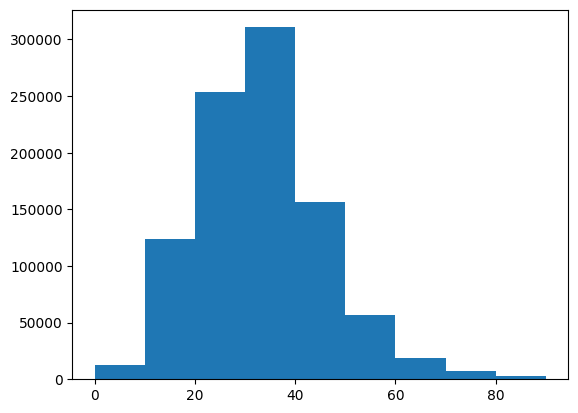

In [19]:
plt.hist(df['new_ratio'],bins = [i for i in range(0,100,10)])

In [20]:
df = df[df['ratio']<0.8]
print(df.shape)
df = df[df['ratio']>0.2]
print(df.shape)

(837701, 9)
(808708, 9)


(array([     0., 107180., 253600., 310732., 137196.,      0.,      0.,
             0.,      0.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <BarContainer object of 9 artists>)

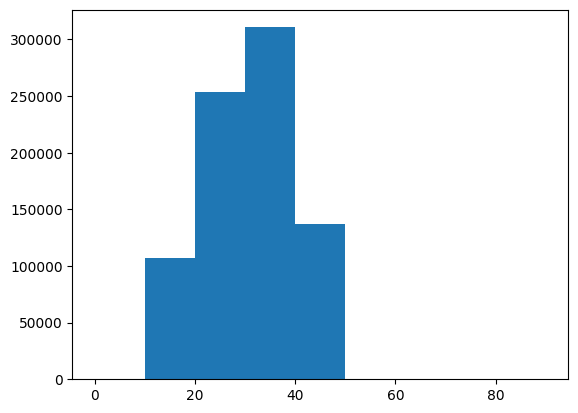

In [21]:
plt.hist(df['new_ratio'],bins = [i for i in range(0,100,10)])

In [22]:
train = df[df["split"]=="train"]
train = train.sample(frac=1,random_state=42)
train

,id,sentence,split,length,sen_length,sen_len,ratio,len_s,new_ratio
654878,adde88325014.mp3,এই চলচ্চিত্রটি পরিচালনা করেছেন সৃজিত মুখোপাধ্য...,train,4.608,6,6,0.768000,276.48,46.080000
859632,e4577b2a33cc.mp3,জীবনের এই সময়েই তিনি গোপীদের সঙ্গে লীলা করেছিলেন।,train,4.968,8,8,0.621000,298.08,37.260000
56175,0ef2befae01a.mp3,"তাঁর সঙ্গে যখনই কথা হয়েছে, দেখেছি সাধারণ কোনে...",train,2.628,12,12,0.219000,157.68,13.140000
855449,e34140cac39d.mp3,আবার কোনো কোনো বইতে তাঁর বাবার নাম অঞ্জন বা জি...,train,6.120,14,14,0.437143,367.20,26.228571
872046,e7a37ce2ca54.mp3,"রাষ্ট্রপতি বাণীতে বলেছেন, জনগণের দোরগোড়ায় স্বা...",train,3.060,11,11,0.278182,183.60,16.690909
...,...,...,...,...,...,...,...,...,...
317902,5466ee04af2f.mp3,ডানদিকে গেলেই আপনার গন্তব্যে পৌঁছে যাবেন।,train,2.736,6,6,0.456000,164.16,27.360000
448580,771e3ace8f68.mp3,কী বলেন ওস্তাদ!,train,2.016,3,3,0.672000,120.96,40.320000
161996,2b0d47596296.mp3,স্মৃতিস্তম্ভের একটি শিলালিপি অনুসারে এটি ইব্রা...,train,5.220,7,7,0.745714,313.20,44.742857
823245,daaa2ca5409e.mp3,বলি বলি করে বলতে পারিনি।,train,3.168,5,5,0.633600,190.08,38.016000


In [23]:
val = df[df["split"]=="valid"]
val = val.sample(frac=1,random_state=42)
val

,id,sentence,split,length,sen_length,sen_len,ratio,len_s,new_ratio
371342,6292c638c31a.mp3,জমির মালিক ছিলেন চট্টগ্রাম মেট্রোপলিটন কলেজের ...,valid,4.680,9,9,0.520000,280.80,31.200000
100224,1aba511e76da.mp3,পুরনো রাজ্যে পিরামিড লিপি থেকে শুরু করে মধ্য র...,valid,8.208,19,19,0.432000,492.48,25.920000
341262,5aa84dea40f6.mp3,তবে তাকে ব্যাট ধরার প্রয়োজন হয়নি।,valid,4.140,6,6,0.690000,248.40,41.400000
432389,72cfeaa988d0.mp3,সুজি পানিতে ভিজিয়ে পেস্ট করে একটি নরম মিশ্রণ ...,valid,8.064,11,11,0.733091,483.84,43.985455
694050,b85482da9744.mp3,একত্রে খাবার গ্রহণ করতে এরা অভ্যস্ত।,valid,3.960,6,6,0.660000,237.60,39.600000
...,...,...,...,...,...,...,...,...,...
504005,85d53163015e.mp3,এটি বাংলাদেশ-ইংল্যান্ডের যৌথ উদ্যোগে প্রতিষ্ঠি...,valid,4.680,7,7,0.668571,280.80,40.114286
907881,f13017e1cba3.mp3,তিনি টেলিভিশন উপস্থাপনা করার পাশাপাশি বেশ কয়ে...,valid,8.316,14,14,0.594000,498.96,35.640000
224991,3bc5dc6f70eb.mp3,এ দম্পতির তিন সন্তান।,valid,3.168,4,4,0.792000,190.08,47.520000
36107,0999a07a1370.mp3,এগুলোকে ব্যাপক দ্বন্দ্বের জন্য সম্ভাব্য ট্রিগা...,valid,6.948,9,9,0.772000,416.88,46.320000


In [24]:
#val= val[val['length']>2]
#val = val[val['sen_length']>3]

In [25]:
df = pd.concat([train,val])

In [26]:
df.shape

(808708, 9)

# NISQA

Download the metadata provided by the organizers from https://www.kaggle.com/competitions/bengaliai-speech/discussion/433469

In [27]:
nis = pd.read_csv("NISQA_wavfiles.csv")
nis.head()

,deg,mos_pred,noi_pred,dis_pred,col_pred,loud_pred,model
0,67af5635e163.wav,2.810660,3.060386,3.349879,3.030119,3.400320,NISQAv2
1,67ff3e6bf4cf.wav,1.781602,2.869787,1.852019,2.256710,3.204139,NISQAv2
2,6741c3d88006.wav,3.304557,3.737251,4.092661,3.244866,3.618690,NISQAv2
3,67c631a6fbfd.wav,3.193850,3.710290,4.136703,2.662462,3.430386,NISQAv2
4,671616b12c10.wav,2.525036,4.105721,2.742880,2.955755,3.561888,NISQAv2


In [28]:
nis.shape

(903346, 7)

In [29]:
nis = nis[nis['mos_pred']>2]
nis = nis[nis['noi_pred']>2]
nis = nis[nis['col_pred']>2]
nis = nis[nis['dis_pred']>2]
nis = nis[nis['loud_pred']>2]
nis.shape

(603422, 7)

In [30]:
nis['deg'] = nis['deg'].apply(lambda x:x[:-4]+".mp3")

In [31]:
good = nis['deg'].tolist()

keep only the good data

In [32]:
df = df[df['id'].isin(good)]
df.shape

(511620, 9)

In [33]:
df = df.sample(frac=1,random_state=42)

In [34]:
def check_eng(x):
    for k in x:
        if k in 'abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            return True
    return False

df['english_ase'] = df['sentence'].apply(lambda x:check_eng(x))

In [35]:
val = df.iloc[:1000]
train = df.iloc[1000:]

In [36]:
mode = "debugg"

if mode=="debug":
    train = train.iloc[:1000]
    val = val.iloc[:100]
else:
    #train = train.iloc[:500000]
    print(val.shape)
    #val = val.iloc[:20000]
    print("Hello")

(1000, 10)
Hello


Add the openslr dataset

In [37]:
openslr = pd.read_csv("openslr.csv")
openslr.shape


(13758, 3)

In [38]:
train.shape

(510620, 10)

In [39]:
tr = pd.concat([train,openslr])
tr = tr.sample(frac=1,random_state=42)
tr

,id,sentence,split,length,sen_length,sen_len,ratio,len_s,new_ratio,english_ase
467902,7c3833a0220f.mp3,সেগুলোয় অনায়াসে জিততাম আমি।,train,2.556,4.0,4.0,0.639000,153.36,38.340000,False
674325,b31934225200.mp3,পদার্থবিদ্যা নিয়ে চিন্তাভাবনাটা পদার্থবিদদের ও...,train,4.500,7.0,7.0,0.642857,270.00,38.571429,False
887713,ebcc55d9377c.mp3,তিনি বারো ইমামের অন্যতম।,train,1.656,4.0,4.0,0.414000,99.36,24.840000,False
693203,b81aed315f86.mp3,ফোনটির ডিসপ্লের মধ্যে ও পেছনে দুই জায়গায় ফিঙ্গ...,train,4.536,9.0,9.0,0.504000,272.16,30.240000,False
785007,d081a1cff657.mp3,কার্যকরী মূলকের নাম থেকেই জৈব যৌগের অণুগুলির ন...,train,5.832,11.0,11.0,0.530182,349.92,31.810909,False
...,...,...,...,...,...,...,...,...,...,...
567941,96c8bbb1ddc4.mp3,সখীকেন্দ্রের মাধ্যমে আমরা চেষ্টা করছি আইনি প্র...,train,6.408,12.0,12.0,0.534000,384.48,32.040000,False
135115,23fd174a6907.mp3,হিসাববিজ্ঞানে ভালো নম্বর পেতে হলে সৃজনশীল ও বহ...,train,5.940,12.0,12.0,0.495000,356.40,29.700000,False
336419,595a152af43f.mp3,তড়িঘড়ি করে ভালকেকে বরখাস্ত করে আপাতত পরিস্থিতি...,train,5.436,12.0,12.0,0.453000,326.16,27.180000,False
431537,7293708e9d30.mp3,"আমাদের এত কুসংস্কার ও কুপ্রথা যে, আমরা ইংরেজের...",train,5.148,12.0,12.0,0.429000,308.88,25.740000,False


In [40]:
#train = tr

In [41]:
train.shape

(510620, 10)

In [43]:
comp = train[["id","sentence"]]
comp.head()

,id,sentence
891053,ecb1bd78a563.mp3,বেশির ভাগ শিক্ষার্থী ভর্তি হচ্ছে একাদশ শ্রেণীর...
193606,33701e9a00eb.mp3,সড়ক ছেড়ে তারা ডান-বাম দিক দিয়ে এবং নৌবাহিনী...
859261,e43d99bffef4.mp3,"যাঁরা দমন করার কর্তা, তাঁদের কাছে নিবেদন, আপনা..."
4363,01272438083a.mp3,বাংলাদেশী ক্রিকেট খেলোয়াড়দের মধ্যে তিনিই প্র...
612531,a295f3b28412.mp3,"সেটির একটা কারণ হতে পারে, অধিনায়কত্বের সঙ্গে ত..."


In [44]:
ids = []
sens = []
with open("utt_spk_text.tsv") as f:
    lines = f.readlines()

    for line in tqdm(lines):
        line = line.split("\t")
        ids.append(line[0]+".mp3")
        sens.append(line[2][:-1])
ids[:5],sens[:5]

100%|██████████| 218703/218703 [00:00<00:00, 2883252.77it/s]


(['000020a912.mp3',
  '000039928e.mp3',
  '00005debc7.mp3',
  '00009e687c.mp3',
  '00012843bc.mp3'],
 ['বাংলাদেশে দায়িত্ব নেবে',
  'এ ধরণের কার্ড নিয়ে',
  'হতে উপার্জিত অর্থ',
  'হাসির বিষয় হয়েই আছে',
  'সার্ক দেশগুলোতে'])

In [45]:
openslr = pd.DataFrame({"id":ids,"sentence":sens})
openslr.head()

,id,sentence
0,000020a912.mp3,বাংলাদেশে দায়িত্ব নেবে
1,000039928e.mp3,এ ধরণের কার্ড নিয়ে
2,00005debc7.mp3,হতে উপার্জিত অর্থ
3,00009e687c.mp3,হাসির বিষয় হয়েই আছে
4,00012843bc.mp3,সার্ক দেশগুলোতে


In [46]:
openslr['len'] = openslr['sentence'].apply(lambda x: len(x.split(" ")))
openslr = openslr[openslr['len']>=3]
openslr.shape

(153600, 3)

In [47]:
openslr = openslr[["id","sentence"]]
openslr.head()

,id,sentence
0,000020a912.mp3,বাংলাদেশে দায়িত্ব নেবে
1,000039928e.mp3,এ ধরণের কার্ড নিয়ে
2,00005debc7.mp3,হতে উপার্জিত অর্থ
3,00009e687c.mp3,হাসির বিষয় হয়েই আছে
5,00012880b1.mp3,সহজেই যাওয়া যায়


In [48]:
train = pd.concat([comp,openslr])
train.shape

(664220, 2)

In [49]:
train.head()

,id,sentence
891053,ecb1bd78a563.mp3,বেশির ভাগ শিক্ষার্থী ভর্তি হচ্ছে একাদশ শ্রেণীর...
193606,33701e9a00eb.mp3,সড়ক ছেড়ে তারা ডান-বাম দিক দিয়ে এবং নৌবাহিনী...
859261,e43d99bffef4.mp3,"যাঁরা দমন করার কর্তা, তাঁদের কাছে নিবেদন, আপনা..."
4363,01272438083a.mp3,বাংলাদেশী ক্রিকেট খেলোয়াড়দের মধ্যে তিনিই প্র...
612531,a295f3b28412.mp3,"সেটির একটা কারণ হতে পারে, অধিনায়কত্বের সঙ্গে ত..."


In [50]:
train.shape

(664220, 2)

In [51]:
train.to_csv("train.csv")

In [52]:
val = pd.read_csv("val.csv")

In [53]:
val.shape

(1000, 10)

In [54]:
train = pd.read_csv("train.csv")
train.shape

(664220, 3)

In [55]:
train = train[["id","sentence"]]

In [56]:
train.shape

(664220, 2)

In [57]:
train.to_csv("train.csv",index=False)

In [58]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       5.0Gi        22Gi        16Mi       3.9Gi        25Gi
Swap:         2.0Gi          0B       2.0Gi


In [59]:
!nvidia-smi

Fri Nov 17 15:45:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4500    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   29C    P8    16W / 200W |     18MiB / 20470MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [86]:
# Training config class.
class Config:
    # Path to audio data directories. Change to directory containing pre-converted and
    # resampled wav files if available, along with audio_ext.
    train_path = "full_data/train_mp3s/"
    valid_path = "full_data/train_mp3s/"
    audio_ext = "mp3"
    sample_rate = 16000
    
    # Path to csv metadata files.
    train_csv_path = "train.csv"
    valid_csv_path = "val.csv"
    
    # Directory where language models are written to.
    language_model_dir = "langauge_models"

    # If True, enables all audio augmentations.
    use_augmentation = False
    
    # Dropout configs for pretrained wav2vec2 model.
    attention_dropout=0.05
    hidden_dropout=0.05
    feat_proj_dropout=0.05
    mask_time_prob=0.05
    layerdrop=0.1
        
    # Early stopping.
    early_stopping_patience = 20

    # Trainer arugments.
    trainer = TrainingArguments(
      output_dir="run-003-wav2vec2-fulldata-cosine-lr3e-5",
      group_by_length=False,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      gradient_accumulation_steps=1,
      eval_accumulation_steps = 300,
      evaluation_strategy="steps",
      num_train_epochs=5,
      gradient_checkpointing=True,
      fp16=True,
      save_steps=10000,
      eval_steps=10000,
      logging_steps=10000,
      learning_rate=3e-5,
      weight_decay = 0.00025,
      #dataloader_num_workers=os.cpu_count()//3,
      warmup_steps=5000,
      save_total_limit=2,
      push_to_hub=False,
      load_best_model_at_end=True,
      #auto_find_batch_size=True,
      prediction_loss_only=False,
      lr_scheduler_type="cosine",
      greater_is_better=False,
      resume_from_checkpoint=True,
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [87]:
skipFiles = []

<a id="3"></a> <br>
## Function Definitions

<a id="3-1"></a> <br>
### Functions for filter and normalizing dataset

In [88]:
def filterVotes(x: pd.Series):
    """
    This function returns whether x should be filtered based on
    the ratio of up to down votes. if it should be filtered, the
    function returns None, otherwise 1. We later use panda's dropna()
    method to drop rows containng None.
    """
    up = x["up_votes"]
    down = x["down_votes"]
    if down > 0 and up / down < 1:
        return None
    return 1

# Regex for matching zero witdh joiner variations.
STANDARDIZE_ZW = re.compile(r'(?<=\u09b0)[\u200c\u200d]+(?=\u09cd\u09af)')

# Regex for removing standardized zero width joiner, except in edge cases.
DELETE_ZW = re.compile(r'(?<!\u09b0)[\u200c\u200d](?!\u09cd\u09af)')

# Regex matching punctuations to remove.
PUNC = re.compile(r'([\?\.।;:-_|*#,!"\'])')

def removeOptionalZW(text):
    """
    Removes all optional occurrences of ZWNJ or ZWJ from Bangla text.
    """
    text = STANDARDIZE_ZW.sub('\u200D', text)
    text = DELETE_ZW.sub('', text)
    return text

def removePunc(text):
    """
    Remove for punctuations from text.
    """
    text = PUNC.sub(r" ", text)
    text = " ".join(text.split())
    return text

def normalizeUnicode(text, normalize_nukta=True):
    """
    Normalizes unicode strings using the Normalization Form Canonical
    Composition (NFC) scheme where we first decompose all characters and then
    re-compose combining sequences in a specific order as defined by the
    standard in unicodedata module. Finally all zero-width joiners are
    removed.
    """
    if normalize_nukta:
        words = [ bnorm(word)['normalized']  for word in text.split() ]
        text = " ".join([word for word in words if word is not None])
        text = text.replace("\u2047", "-")

    text = text.replace(u"\u098c", u"\u09ef")
    text = unicodedata.normalize("NFC", text)
    text = removeOptionalZW(text)
    text = removePunc(text)

    return text

<a id="3-2"></a> <br>
### Audio Loader Class and PyTorch Dataset

- This class transcodes and augments audio files and can be used with PyTorch dataloaders.

In [89]:
class AudioConverter:
    """
    AudioConverter offers methods to load, transcode and augment
    audio data in various ways.
    """

    # Configurations for parameters used in torchaudio's resampling kernel.
    resampleFilterParams = {
        "fast": {  # Fast and less accurate but still MSE = ~2e-5 compared to librosa.
            "lowpass_filter_width": 16,
            "rolloff": 0.85,
            "resampling_method": "kaiser_window",
            "beta": 8.555504641634386,
        },
        "best": { # Twice as slow, and a little bit more accburate.
            "lowpass_filter_width": 64,
            "rolloff": 0.9475937167399596,
            "resampling_method": "kaiser_window",
            "beta": 14.769656459379492,       
        },
    }

    def __init__(
        self,
        sampleRate: int,
        disableAug: bool = False,
        speedAugProb: float = 0.5,
        volAugProb: float = 0.5,
        reverbAugProb: float = 0.25,
        noiseAugProb: float = 0.25,
        speedFactors: Tuple[float, float] = None,
        volScaleMinMax: Tuple[float, float] = None,
        reverbRoomScaleMinMax: Tuple[float, float] = None,
        reverbHFDampingMinMax: Tuple[float, float] = None,
        reverbSustainMinMax: Tuple[float, float] = None,
        noiseSNRMinMax: Tuple[float, float] = None,
        noiseFileList: List[str] = None,
    ):
        """
        Initializes AudioConverter.

        Parameters
        ----------
        sampleRate: int
            Sampling rate to convert audio to, if required.

        disableAug: bool, optional
            If True, overrides all other augmentation configs and
            disables all augmentatoins.

        speedAugProb: float, optional
            Probability that speed augmentation will be applied.
            If <= 0, speed augmentation is disabled.

        volAugProb: float, optional
            Probability that volume augmentation will be applied.
            If <= 0, volume augmentation is disabled.

        reverbAugProb: float, optional
            Probability that reverberation augmentation will be applied.
            If <= 0, reverberation augmentation is disabled.

        noiseAugProb: float, optional
            Probability that noise augmentation will be applied.
            If <= 0, noise augmentation is disabled.

        speedFactors: List[float], optional
            List of factors by which to speed up (>1) or slow down (<1)
            audio by. One factor is chosen randomly if provided. Otherwise,
            default speed factors are [0.9, 1.0, 1.0].
            
        volScaleMinMax: Tuple[float, float], optional
            [Min, Max] range for volume scale factors. One factor is
            chose randomly with uniform probability from this range.
            Default range is [0.125, 2.0].

        reverbRoomScaleMinMax: Tuple[float, float], optional
            [Min, Max] range for room size percentage. Values must be
            between 0 and 100. Larger room size results in more reverb.
            Default range is [25, 75].

        reverbHFDampingMinMax: Tuple[float, float], optional
            [Min, Max] range for high frequency damping percentage. Values must
            be between 0 and 100. More damping results in muffled sound.
            Default range is [25, 75].
        
        reverbSustainMinMax: Tuple[float, float], optional
            [Min, Max] range for reverberation sustain percentage. Values must
            be between 0 and 100. More sustain results in longer lasting echoes.
            Default range is [25, 75].
            
        noiseSNRMinMax: Tuple[float, float], optional
            [Min, Max] range for signal-to-noise ratio when adding noise. One
            factor is chose randomly with uniform probability from this range.
            Lower SNR results in louder noise. Default range is [10.0, 30.0].

        noiseFileList: List[str], optional
            List of paths to audio files to use as noise samples. If None is provided,
            noise augmentation will be disabled. Otherwise, the audio files will be assumed
            to be sources of noise, and be mixed in with speech audio on-the-fly.
        """
        self.sampleRate = sampleRate
        
        enableAug = not disableAug
        self.speedAugProb = speedAugProb if enableAug else -1
        self.volAugProb = volAugProb if enableAug else -1
        self.reverbAugProb = reverbAugProb if enableAug else -1
        self.noiseAugProb = noiseAugProb if enableAug else -1
        
        # Factors by which audio speed is perturbed.
        self.speedFactors = speedFactors
        if speedFactors is None:
            self.speedFactors = [0.9, 1.0, 1.1]
        
        # [Min, Max] Volume scale range.
        self.volScaleRange = volScaleMinMax
        if volScaleMinMax is None:
            self.volScaleRange = [0.125, 2.0]
        
        # [Min, Max] Room size as a percentage, higher = more reverb
        self.reverbRoomScaleRange = reverbRoomScaleMinMax
        if reverbRoomScaleMinMax is None:
            self.reverbRoomScaleRange = [25, 75]
        
        # [Min, Max] High frequency damping as a percentage, higher = more damping.
        self.reverbHFDampingRange = reverbHFDampingMinMax
        if reverbHFDampingMinMax is None:
            self.reverbHFDampingRange = [25, 75]
        
        # [Min, Max] How long reverb is sustained as a percentage, higher = lasts longer.
        self.reverbSustainRange = reverbSustainMinMax 
        if reverbSustainMinMax is None:
            self.reverbSustainRange = [25, 75]       

        # Audio files to use as source of noise.
        self.noiseFiles = noiseFileList
        if self.noiseFiles is None or len(self.noiseFiles) == 0:
            self.noiseAugProb = -1

        # [Min, Max] Signal to noise ratio range for adding noise to audio.
        # Lower SNR = noise is more prominent, i.e. speech is more noisy.
        self.noiseSNRRange = noiseSNRMinMax
        if noiseSNRMinMax is None:
            self.noiseSNRRange = [10.0, 30.0]
        
        self.validateConfig()
        
    def validateConfig(self):
        """
        Checks configured options and raises an error if they
        are not consistent with what is expected.
        """
        if len(self.volScaleRange) != 2:
            raise ValueError("volume scale range must be provided as [min, max]")
        if len(self.reverbRoomScaleRange) != 2:
            raise ValueError("reverb room scale range must be provided as [min, max]")
        if len(self.reverbHFDampingRange) != 2:
            raise ValueError("reverb high frequency dampling range must be provided as [min, max]")
        if len(self.reverbSustainRange) != 2:
            raise ValueError("reverb sustain range must be provided as [min, max]")
        if len(self.noiseSNRRange) != 2:
            raise ValueError("noise SNR range must be provided as [min, max]")
            
        for v in self.reverbRoomScaleRange:
            if v > 100 or v < 0:
                raise ValueError("reverb room scale must be between 0 and 100")
        for v in self.reverbHFDampingRange:
            if v > 100 or v < 0:
                raise ValueError("reverb high frequency dampling must be between 0 and 100")
        for v in self.reverbSustainRange:
            if v > 100 or v < 0:
                raise ValueError("reverb sustain range must be between 0 and 100")

    @classmethod
    def loadAudio(
        cls, audioPath: str, sampleRate: int = None, returnTensor: bool = True, resampleType: str = "fast",
    ) -> Union[torch.Tensor, np.ndarray]:
        """
        Uses torchaudio to load and resample (if necessary) audio files and returns
        audio samples as either a numpy.float32 array or a torch.Tensor.
        
        Parameters
        ----------
        audioPath: str
            Path to audio file file (wav / mp3 / flac).
        
        sampleRate: int, optional
            Sampling rate to convert audio to. If None,
            audio is not resampled.
        
        returnTensor: bool, optional
            If True, the audio samples are returned as a torch.Tensor.
            Otherwise, the samples are returned as a numpy.float32 array.
            
        resampleType: str, optional
            Either "fast" or "best" - sets the quality of resampling.
            "best" is twice as slow as "fast" but more accurate. "fast"
            is still comparable to librosa's resampled output though,
            in terms of MSE.

        Returns
        -------
        Union[torch.Tensor, np.ndarray]
            Audio waveform scaled between +/- 1.0 as either a numpy.float32 array,
            or torch.Tensor, with shape (channels, numSamples)
        """
        x, sr = torchaudio.load(audioPath)
        if sampleRate is not None or sr != sampleRate:
             x = F.resample(x, sr, sampleRate, **cls.resampleFilterParams[resampleType])
        
        if returnTensor:
            return x
        
        return x.numpy()

    def getAudio(self, audioPath: str, returnTensor: bool = False) -> Union[np.ndarray, torch.Tensor]:
        """
        Loads audio from specified path and applies augmentations randomly
        on-the-fly. Audio samples scaled between -1.0 and +1.0 are returned
        as a numpy.float32 array or torch.Tensor with shape (numSamples,).

        Parameters
        ----------
        audioPath: str
            Path to audio file file (wav / mp3 / flac).
        
        returnTensor: bool, optional
            If True, the audio samples are returned as a torch.Tensor.
            Otherwise, the samples are returned as a numpy.float32 array.
        
        Returns
        ------- 
        Union[torch.Tensor, np.ndarray]
            Audio waveform scaled between +/- 1.0 as either a numpy.float32 array,
            or torch.Tensor, with shape (channels, numSamples)
        """
        wav = self.loadAudio(
            audioPath, sampleRate=self.sampleRate, returnTensor=True, resampleType="best",
        )

        # Applying sox-based effects first.
        effects = []
        
        if random.uniform(0, 1) <= self.speedAugProb:
            effects.extend([
                ["speed", f"{random.choice(self.speedFactors)}"],
                ["rate", f"{self.sampleRate}"],
            ])

        if random.uniform(0, 1) <= self.reverbAugProb:
            effects.append([
                "reverb",
                f"{random.uniform(*self.reverbSustainRange)}",
                f"{random.uniform(*self.reverbHFDampingRange)}",
                f"{random.uniform(*self.reverbRoomScaleRange)}",
            ])
        
        # If no effects are selected, this is a no-op.
        wav = self.applySoxEffects(wav, effects)

        if random.uniform(0, 1) <= self.noiseAugProb:
            noiseFile = random.choice(self.noiseFiles)
            noiseSNR = random.uniform(*self.noiseSNRRange)
            wav = self.addNoiseFromFile(wav, noiseFile, noiseSNR)

        if random.uniform(0, 1) <= self.volAugProb:
            volScale = random.uniform(*self.volScaleRange)
            wav = self.scaleVolume(wav, volScale)
        
        if returnTensor:
            return wav
        
        return wav.numpy()


    def scaleVolume(self, wav: Union[np.ndarray, torch.Tensor], scale: float) -> torch.Tensor:
        """
        Scales the amplitude (with clipping) of the provided audio signal
        by the given scale factor.
        
        Parameters
        ----------
        wav: Union[np.ndarray, torch.Tensor]
             Audio samples scaled between -1.0 and +1.0, with shape
             (channels, numSamples).

        Returns
        -------
        torch.Tensor
            Audio samples with perturbed volume.
        """
        if scale == 1.0:
            return wav

        return torch.clamp(wav * scale, -1.0, 1.0)

    def addNoiseFromFile(
        self, wav: Union[np.ndarray, torch.Tensor], noiseFile: str, snr: float,
    ) -> torch.Tensor:
        """
        Adds noise signal from provided noise audio file at the 
        specified SNR to the speech signal.
        
        Parameters
        ----------
        wav: Union[np.ndarray, torch.Tensor]
             Audio samples scaled between -1.0 and +1.0, with shape
             (channels, numSamples).

        snr: float
            Signal-to-Noise ratio at which to mix in the noise signal.
        
        Returns
        -------
        torch.Tensor
            Audio samples with noise added at specified SNR.
        """
        # Loading noise signal.
        noiseSig = self.loadAudio(
            noiseFile, sampleRate=self.sampleRate, returnTensor=True, resampleType="fast",
        )

        # Computing noise power.
        noisePower = torch.mean(torch.pow(noiseSig, 2))
        
        # Computing signal power.
        signalPower = torch.mean(torch.pow(wav, 2))

        # Noise Coefficient for target SNR; amplitude coeff is sqrt of power coeff.
        noiseScale = torch.sqrt((signalPower / noisePower) / (10 ** (snr / 20.0)))
        
        # Add noise at random location in speech signal.
        nWav, nNoise = wav.shape[-1], noiseSig.shape[-1]

        if nWav < nNoise:
            a = random.randint(0, nNoise-nWav)
            b = a + nWav
            return wav + (noiseSig[..., a:b] * noiseScale)
        
        a = random.randint(0, nWav-nNoise)
        b = a + nNoise          
        wav[..., a:b] += (noiseSig * noiseScale)

        return wav
    
        
    def applySoxEffects(self, wav: Union[np.ndarray, torch.Tensor], effects: List[List[str]]) -> torch.Tensor:
        """
        Applies different audio manipulation effects to provided audio, like
        speed and volume perturbation, reverberation etc. For a full list of
        supported effects, check torchaudio.sox_effects.

        Parameters
        ----------
        wav: Union[np.ndarray, torch.Tensor]
             Audio samples scaled between -1.0 and +1.0, with shape
             (channels, numSamples).
        
        effects: List[List[str]]
            List of sox effects and associated arguments, example:
            '[ ["speed", "1.2"], ["vol", "0.5"] ]'

        Returns
        -------
        torch.Tensor
            Audio samples with effects applied. May not be the same
            number of samples as input sample array, depending on types
            of effects applied (e.g. speed perturbation may reduce or
            increase the number of samples).
        """
        if effects is None or len(effects) == 0:
            return wav

        wav, _ = torchaudio.sox_effects.apply_effects_tensor(
            wav, sample_rate=self.sampleRate, effects=effects,
        )

        return wav
    
    def perturbSpeed(self, wav: Union[np.ndarray, torch.Tensor], factor: float) -> torch.Tensor:
        """
        Perturbs the speed of the provided audio signal by the given factor.
        
        Parameters
        ----------
        wav: Union[np.ndarray, torch.Tensor]
             Audio samples scaled between -1.0 and +1.0, with shape
             (channels, numSamples).

        Returns
        -------
        torch.Tensor
            Audio samples with perturbed speed. Will have more or less
            samples than input depending on whether slowed down or
            sped up.
        """
        effects = [
            ["speed", f"{factor}"],
            ["rate", f"{self.sampleRate}"],
        ]
        
        return self.applySoxEffects(wav, effects)
    
    def addReverb(
        self, wav: Union[np.ndarray, torch.Tensor], roomSize: float, hfDamping: float, sustain: float,
    ) -> torch.Tensor:
        """
        Adds reverberation to the provided audio signal using given parameters.
        
        Parameters
        ----------
        wav: Union[np.ndarray, torch.Tensor]
             Audio samples scaled between -1.0 and +1.0, with shape
             (channels, numSamples).
        
        roomSize: float
            Room size as a percentage between 0 and 100,
            higher = more reverb

        hfDamping: float
            High Frequency damping as a percentage between 0 and 100,
            higher = more damping.

        sustain: float
            How long reverb is sustained as a percentage between 0 and 100,
            higher = lasts longer.

        Returns
        -------
        torch.Tensor
            Audio samples with reverberated audio.
        """
        effects = [["reverb", f"{roomSize}", f"{hfDamping}", f"{sustain}"]]
        return self.applySoxEffects(wav, effects)

- This PyTorch Dataset class uses the AudioConverter class to load audio files parallely.

In [90]:
class CompDataset(Dataset):
        
    def __init__(self, df, processor, audioConverter, loopDataset=1):
        self.df = df
        self.paths = df['id']
        self.sentences = df['sentence']
        self.len = len(self.df) * loopDataset

        self.processor = processor
        self.ac = audioConverter

    def __len__(self):
        return self.len

    def loadSample(self, idx):
        idx %= len(self.df)
        audio_path = self.paths[idx]
        sentence = self.sentences[idx]

        wave = self.ac.getAudio(audio_path)[0]
        input_values = processor(wave, sampling_rate=16000).input_values[0]

        input_length = len(input_values)
        with self.processor.as_target_processor():
            labels = self.processor(sentence).input_ids

        return {
            'input_values':input_values,
            'input_length':input_length,
            'labels':labels
        }

    def __getitem__(self, idx): 
        if idx >= self.len:
            raise IndexError('index out of range')
        return self.loadSample(idx)

In [91]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

<a id="4"></a> <br>
## Main

In [92]:
# Testing punctuation removal
text = "আমার আ,ম; ;?অনেক?! .ভাল: 'লাগে"
display(HTML(f"original: {text}"))
display(HTML(f"puncs removed: {removePunc(text)}"))

In [93]:
# Loading metadata files.
train_df = pd.read_csv(Config.train_csv_path)
valid_df = pd.read_csv(Config.valid_csv_path)

print(f"Train utts before filtering: {len(train_df)}")

# Removing files that we encountered errors in a previous runs.
train_df = train_df[~train_df['id'].isin(skipFiles)]
train_df = train_df.reset_index()
valid_df = valid_df.reset_index()

print(f"Train utts after filtering: {len(train_df)}")

Train utts before filtering: 664220
Train utts after filtering: 664220


<a id="4-1"></a> <br>
### Build Language Model

- The language model is built using KenLM tooklit (https://github.com/kpu/kenlm).
- We trained the LM separately. The Notebook can be found here : https://www.kaggle.com/code/mbmmurad/fork-of-creating-n-gram-language-model-for-wav2vec/notebook

In [ ]:
# Apply unicode normalization.
print("Normalizing training and validation transcripts... ")
train_df["sentence"] = [ normalizeUnicode(x) for x in tqdm(train_df["sentence"]) ]
valid_df["sentence"] = [ normalizeUnicode(x) for x in tqdm(valid_df["sentence"]) ]

In [ ]:


# Updating paths to point to data directories.
train_df["id"] = [ os.path.join(Config.train_path, x.replace("mp3", Config.audio_ext)) for x in train_df['id'] ]
valid_df["id"] = [ os.path.join(Config.valid_path, x.replace("mp3", Config.audio_ext)) for x in valid_df['id'] ]

# Keeping only audio filename and transcript columns.
train_df = train_df[["id","sentence"]]
valid_df = valid_df[["id","sentence"]]

In [ ]:
# Checking a sample from the train dataframe.
sample = train_df.iloc[random.randint(0, len(train_df))]

display(HTML(sample['sentence']))

x = AudioConverter.loadAudio(sample['id'], sampleRate=Config.sample_rate, returnTensor=False)
display(Audio(x, rate=Config.sample_rate))

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# model = Wav2Vec2ForCTC.from_pretrained("Sameen53/CV_bn_trained_on_Train_0.3", ctc_loss_reduction="mean")
# processorLM = Wav2Vec2ProcessorWithLM.from_pretrained("arijitx/wav2vec2-xls-r-300m-bengali")
processor = Wav2Vec2Processor.from_pretrained("ai4bharat/indicwav2vec_v1_bengali")

In [ ]:
# Creating dataset objects for train and val.
disable_aug = not Config.use_augmentation
loop_train_dataset = 2
loop_val_datset = 1

train_ac = AudioConverter(sampleRate=Config.sample_rate, disableAug=disable_aug, noiseFileList=train['id'].tolist())
val_ac = AudioConverter(sampleRate=Config.sample_rate, disableAug=True)

train_dataset = CompDataset(train_df, processor, train_ac, loop_train_dataset)
valid_dataset = CompDataset(valid_df, processor, val_ac, loop_val_datset)

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
vocab_dict_cn = processor.tokenizer.get_vocab()

In [ ]:
vocab_dict_nc={v:k for k,v in vocab_dict_cn.items()}
vocab = list(vocab_dict_cn.keys())

with open('vocab.json', 'w') as f:
    json.dump(vocab_dict_cn, f)
    
print(f"vocabulary size = {len(vocab)}")

In [ ]:
# Checking sample from dataset.
sample = train_dataset[123]
pprint(sample)

x = sample['input_values']
y = [ vocab_dict_nc[x] for x in sample['labels'] ]

display(HTML(str(y)))
display(Audio(x, rate=Config.sample_rate))

### Callback for computing metrics

In [ ]:
wer_metric = load_metric("deps//metrics/metrics/wer.py")
cer_metric = load_metric("deps//metrics/metrics/cer.py")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id
    
    # We do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

<a id="4-2"></a> <br>
### Loading base Wav2Vec2 model from HuggingFace

- We use a pretrained Wav2Vec2 model from Hugging Face as a starting point.
- Model Link: https://huggingface.co/ai4bharat/indicwav2vec_v1_bengali
- The datasets and pretraining can be found here : https://github.com/AI4Bharat/IndicWav2Vec

In [ ]:
from transformers import Wav2Vec2ConformerForCTC

In [ ]:
base_model = "ai4bharat/indicwav2vec_v1_bengali"

# Loading model.
model = Wav2Vec2ForCTC.from_pretrained(
    base_model, 
    resume_download=True,
    ignore_mismatched_sizes=True,
    attention_dropout=Config.attention_dropout,
    hidden_dropout=Config.hidden_dropout,
    feat_proj_dropout=Config.feat_proj_dropout,
    mask_time_prob=Config.mask_time_prob,
    layerdrop=Config.layerdrop,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

# Freezing encoder layers.
model.freeze_feature_encoder()
model.config.ctc_zero_infinity = True
model.config.diversity_loss_weight=100

# Printing stats.
total_param = sum(p.numel() for p in model.parameters())
trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total_param = {total_param}")
print(f"trainable = {trainable_param}")

<a id="4-3"></a> <br>
### Adapting Wav2Vec2 Model

- First run with cosine lr decay schedule, dropouts enabled

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=Config.trainer,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,   
    tokenizer=processor.feature_extractor,
    callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience=Config.early_stopping_patience)],
)

In [ ]:
import gc
gc.collect()
gc.collect()
gc.collect()

In [ ]:
!nvidia-smi

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("best_model")